In [1]:
import obspy
import seisbench.models as sbm
import matplotlib.pyplot as plt
import numpy as np

import ipynb.fs 
from .defs.EDA_and_Preprocessing import Data_Sorter
from .defs.Load_and_Store_Models import load_models_pickle, store_models

In [2]:
'''
Takes in a dictionary with the stored files, the key that contains
the desired file and the path to the files.
'''

def stream_creator(path, dict, key, plot=None):
    stream = obspy.read(path + dict[key][0])
    stream += obspy.read(path + dict[key][1])
    stream += obspy.read(path + dict[key][2])
    
    if plot:
        fig = plt.figure(figsize=(8,6))
        stream.plot(bgcolor='gainsboro', fig=fig)
    
    return stream

In [3]:
'''
 Takes as arguments the original stream, the denoiser model and a boolean for plotting.
 Returns a stream object that has been 'denoised'.
'''
def denoiser(stream, model, plot=None):    
    denoised_stream = model.annotate(stream)
    
    if plot:
        fig = plt.figure(figsize=(8,6))
        denoised_stream.plot(bgcolor='gainsboro', fig=fig)
    
    return denoised_stream

In [4]:
'''
 Takes as arguments the original stream, the specified model and a threshold for the P/S threshold.
 Returns a stream object that has been evaluated with the specificed model.
'''
def annotate(stream, model, threshold):
    predictions = {}
    
    predictions['annotation'] = model.annotate(stream)
    predictions['picks'] = model.classify(stream, P_threshold=threshold, S_threshold=threshold)
    
    return predictions

In [5]:
'''
 This function pickles and stores the evaluated models as files and stores them in a folder 
 in path named after the station id number. This is done in order to save time so that more time 
 can be used for other analysis.
 
 Arguments: station id number, the the evaluated stream, the model used and the pretrained dataset
 that the model was trained on.
'''

def store_annotated_streams(station, predicted_stream, model, data_set):
    filename = f"Station_{station}_Annotations/{model}_{data_set}" 
    
    return store_models(filename, predicted_stream)

In [6]:
def peak_index_getter(prediction_annotations, threshold):
    ind_dict = {}
    
    for annotation in prediction_annotations:
        channel = annotation.stats.channel[-1]
        if annotation.stats.channel[-1] != "N": # Noise channel
            data = annotation.data
            data = np.atleast_1d(data).astype('float64')
            
            dx = data[1:] - data[:-1]

            ind = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]

            if ind.size:
                    ind = ind[data[ind] >= threshold]
            
            ind_dict[f"{channel}_channel_ind"] = ind

        
    return ind_dict

In [7]:
''' Picks out the station data that we will use. '''
path = '/global/scratch/users/taira/mleq/mseed/'
collected_data = !ls /global/scratch/users/taira/mleq/mseed/

sorted_dict = Data_Sorter(collected_data)

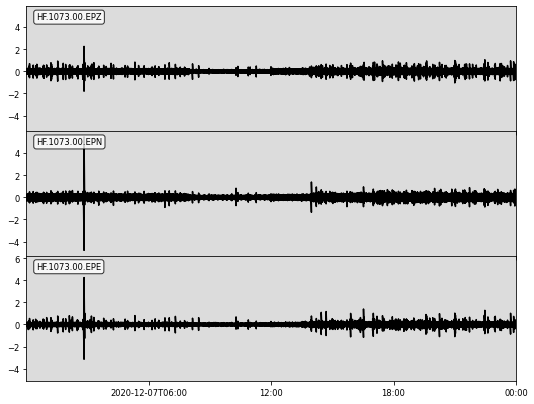

In [8]:
''' Initializes the stream. '''
stream = stream_creator(path, sorted_dict, '1073', True)

In [9]:
''' Loads the nested dictionaries that hold all of the pretrained models from the pickled file. '''
models = load_models_pickle('models_pickle')
print(models.keys(), '\n\n', models['gpd_model'].keys())

dict_keys(['pn_model', 'eqt_model', 'gpd_model', 'denoiser']) 

 dict_keys(['original', 'ethz', 'scedc', 'stead'])


In [10]:
''' Runs the selected model on the original and denoised stream. '''
# predictions = annotate(stream, models['gpd_model']['original'], threshold=.95)

' Runs the selected model on the original and denoised stream. '

In [11]:
''' Pickles the selected evaluated models, or, gets the saved trained models for a specific station. '''
# store_annotated_streams('1073', predictions, 'gpd_model', 'original')
gpd_original_predictions = load_models_pickle('Station_1073_Annotations/gpd_model_original')

In [12]:
peak_ind_dict = peak_index_getter(gpd_original_predictions['annotation'], .99)
peak_ind_dict.keys()

dict_keys(['P_channel_ind', 'S_channel_ind'])

In [13]:
print(f"P_channel probabilites above .99:\n {gpd_original_predictions['annotation'][0].data[peak_ind_dict['P_channel_ind']]}")
print(f"\nS_channel probabilites above .99:\n {gpd_original_predictions['annotation'][1].data[peak_ind_dict['S_channel_ind']]}")

P_channel probabilites above .99:
 [ 0.99429816  0.9932768   0.99118304  0.99195546  0.99284863  0.9953732
  0.99014866  0.99356693  0.9913658   0.99468994  0.9907256   0.99597687
  0.990256    0.99394625  0.99793786  0.9903252   0.99114686  0.99436474
  0.9924926   0.9968131   0.99535275  0.99051535  0.99384576  0.99337465
  0.9957216   0.99164784  0.9927644   0.9910353   0.99078476  0.9917447
  0.9946483   0.9946859   0.99133354]

S_channel probabilites above .99:
 [ 0.9941889   0.9931132   0.9925564   0.99340135  0.9993011   0.9913351
  0.9998153   0.9958098   0.9928598   0.99422485  0.99134225  0.99038845
  0.99929464  0.99510914  0.99775475  0.9968935   0.9972479 ]
